# Objetivos

Primeiro, algumas variáveis serão descartadas pelo acúmulo de importância (~90%) e pelo valor de IV.

Segundo, com o uso da validação cruzada: será avaliado o comportamento médio de algumas métricas calculadas nos modelos baselines como a curva sobre a curva precision e recall (AUCPR), Brier Score (BS) e log-loss; foi visto que a identificação de um melhor ponto de corte pode melhorar a métrica F1-score. Dessa forma, será calculado qual o melhor ponto de corte médio.

Terceiro, será escolhido qual o melhor conjunto de hiperparâmetros para os modelos Random Forest e XGBoost. É importante lembrar que a escolha deve ser baseada no trade off entre viés e variância, ou seja, busca-se o equilíbrio para as métricas em treino e validação.

# Pacotes

In [21]:
#!pip install hyperopt

In [32]:
from deltalake import DeltaTable, write_deltalake
import mlflow
from mlflow.models import infer_signature
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import Funcoes
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, accuracy_score, average_precision_score, brier_score_loss, confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_recall_curve, log_loss
import xgboost as xgb
from hyperopt import fmin, tpe, Trials, hp
from functools import partial

# Leitura da base v1 e filtro de variáveis

Variáveis com valor acumulado de importância em ~90% e pelo valor de IV.

In [33]:
# A chance de ser ou não churn não depende do sexo ser M ou F. Mas, ela pode ser uma proxy para comportamentos socioeconômicos como diferença de renda, ocupação em 
# atividades não remuneradas (múltiplas jornadas de trabalho) etc

# Estado civil e número de dependentes podem ser interpretados de forma semelhante. Ambas podem direcionar para um maior compromisso com a estabilidade financeira,
# pessoas com mais idade e, possivelmente, com principalidade de uso do cartão já definida.

dados = DeltaTable("../1.Variaveis/tmp/dados_pp_v1").to_pandas()
dados.drop(['__index_level_0__', 'Card_Category_Gold', 'Card_Category_Platinum', 'Card_Category_Silver', 
            'Marital_Status_Married', 'Marital_Status_Single', 'Marital_Status_Unknown', 'Gender_M',
            'Dependent_count'], axis=1, inplace=True)
dados.head()

,Customer_Age,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Ct_Chng_Q4_Q1,vfm,pmcc,Income_Category_1.< 40k,Income_Category_2. >= 40k & < 60k,Income_Category_3. >= 60k & < 80k,Income_Category_4. >= 80k & < 120k,Income_Category_5. >= 120k,Education_Level_v2_1.Uneducated,Education_Level_v2_2.High School,Education_Level_v2_3.Graduate,Education_Level_v2_4.Post-Graduate,Attrition_Flag,type
0,-0.784196,1.403132,-1.337898,0.498943,0.963894,0.282975,-0.328225,-0.175537,-0.421450,1,0,0,0,0,0,0,1,0,0,Treino
1,0.720070,-0.525933,0.641818,1.408428,-0.165769,-1.527806,-0.194304,-0.208685,-1.054789,0,0,0,1,0,0,0,1,0,0,Treino
2,1.346848,-0.525933,-0.348040,0.498943,0.864865,0.894171,0.056797,-0.571459,-0.686436,0,0,0,1,0,0,0,0,1,0,Treino
3,0.218648,-0.525933,0.641818,-1.320028,-0.412731,0.369637,0.851953,0.252749,2.406712,1,0,0,0,0,0,0,1,0,0,Treino
4,-2.539173,0.117089,1.631675,1.408428,-0.858972,0.346832,-1.144306,-0.064053,-0.071911,1,0,0,0,0,1,0,0,0,0,Treino


In [3]:
dados.duplicated().sum()

np.int64(0)

In [4]:
dados.shape

(10127, 20)

# Separação das bases

In [34]:
dados_treino = dados[dados.type == 'Treino'].drop(['type'], axis=1)
dados_val = dados[dados.type == 'Validacao'].drop(['type'], axis=1)
dados_teste = dados[dados.type == 'Teste'].drop(['type'], axis=1)

In [35]:
X_treino = dados_treino.drop(['Attrition_Flag'], axis=1)
y_treino = dados_treino['Attrition_Flag']

X_val = dados_val.drop(['Attrition_Flag'], axis=1)
y_val = dados_val['Attrition_Flag']

In [15]:
y_treino.value_counts(), y_val.value_counts(), dados_teste['Attrition_Flag'].value_counts()

(Attrition_Flag
 0    6140
 1    1175
 Name: count, dtype: int64,
 Attrition_Flag
 0    1084
 1     208
 Name: count, dtype: int64,
 Attrition_Flag
 0    1276
 1     244
 Name: count, dtype: int64)

In [16]:
# Será usado 5 folds de validação, para que a quantidade absoluta de churn seja equiparada a base de validação e teste (ver acima)
1175/5

235.0

# Validação cruzada

Para ter uma avaliação mais precisa dos modelos baselines, será usada a validação cruzada. É importante ter em mente que precisa-se de uma quantidade razoável da variável target para o estudo, além de se assemelhar com a proporção verdadeira na base completa (~16%).

Para calcular os escores, das diferentes métricas, foi usado o cross_val_score (https://scikit-learn.org/1.5/modules/cross_validation.html).

Para a escolha das métricas de estudo, pode-se escolher pela lista definida em 3.4.3.1 (https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).

## Random Forest

In [22]:
# Construção dos folds de forma estratificada para garantir a mesma representatividade da target

SKF = StratifiedKFold(n_splits=5, shuffle=True, random_state=563)

#  Instancia a Random Forest

rf = RandomForestClassifier(random_state=123)

# Aplicação da validação cruzada e obtenção dos escores

auc_pr_rf = cross_val_score(estimator=rf, X=X_treino, y=y_treino, cv=SKF, scoring='average_precision')
bs_rf = cross_val_score(estimator=rf, X=X_treino, y=y_treino, cv=SKF, scoring='neg_brier_score')
log_loss_rf = cross_val_score(estimator=rf, X=X_treino, y=y_treino, cv=SKF, scoring='neg_log_loss')

No mlflow, os valores de AUCPR e BS na base de validação foram, respectivamente, 0.80 e 0.06. Comparado com o resultado médio das métricas abaixo, pode-se concluir que o modelo com os hiperparâmetros default está com performance boa.

In [24]:
print('Valor médio de AUCPR:', auc_pr_rf.mean())
print('Desvio padrão de AUCPR:', auc_pr_rf.std())

print('----------------------------------------')

print('Valor médio do BS:', bs_rf.mean()*(-1))
print('Desvio padrão do BS:', bs_rf.std())

print('----------------------------------------')

print('Valor médio da log-loss:', log_loss_rf.mean()*(-1))
print('Desvio padrão da log-loss:', log_loss_rf.std())

Valor médio de AUCPR: 0.8110720675084535
Desvio padrão de AUCPR: 0.018858549324494565
----------------------------------------
Valor médio do BS: 0.06355405331510594
Desvio padrão do BS: 0.0023251419277794854
----------------------------------------
Valor médio da log-loss: 0.23914582093998044
Desvio padrão da log-loss: 0.017892713962885703


## XGBoost

In [6]:
# Ao usar o XGBoost, as colunas não podem ter sinais de '>', '>=', '<' e '<='
X_treino_new = X_treino.rename(columns={'Income_Category_1.< 40k': 'Income_Category_1.40k',
                                        'Income_Category_2. >= 40k & < 60k': 'Income_Category_2.40k_60k',
                                        'Income_Category_3. >= 60k & < 80k': 'Income_Category_3.60k_80k',
                                        'Income_Category_4. >= 80k & < 120k': 'Income_Category_4.80k_120k',
                                        'Income_Category_5. >= 120k': 'Income_Category_5.120k'
                                        })

X_val_new = X_val.rename(columns={'Income_Category_1.< 40k': 'Income_Category_1.40k',
                                        'Income_Category_2. >= 40k & < 60k': 'Income_Category_2.40k_60k',
                                        'Income_Category_3. >= 60k & < 80k': 'Income_Category_3.60k_80k',
                                        'Income_Category_4. >= 80k & < 120k': 'Income_Category_4.80k_120k',
                                        'Income_Category_5. >= 120k': 'Income_Category_5.120k'
                                        })

In [27]:
# Construção dos folds de forma estratificada para garantir a mesma representatividade da target

SKF = StratifiedKFold(n_splits=5, shuffle=True, random_state=563)

#  Instancia a XGBoost

XGB = xgb.XGBClassifier(random_state=123)

# Aplicação da validação cruzada e obtenção dos escores

auc_pr_XGB = cross_val_score(estimator=XGB, X=X_treino_new, y=y_treino, cv=SKF, scoring='average_precision')
bs_XGB = cross_val_score(estimator=XGB, X=X_treino_new, y=y_treino, cv=SKF, scoring='neg_brier_score')
log_loss_XGB = cross_val_score(estimator=XGB, X=X_treino_new, y=y_treino, cv=SKF, scoring='neg_log_loss')

No mlflow, os valores de AUCPR e BS na base de validação foram, respectivamente, 0.85 e 0.05. Comparado com o resultado médio das métricas abaixo, pode-se concluir que o modelo com os hiperparâmetros default está com performance boa.

Em média os valores das métricas são melhores para o XGB, entretanto perdem um pouco em relação à variância que é um pouco maior (trade-off).

In [28]:
print('Valor médio de AUCPR:', auc_pr_XGB.mean())
print('Desvio padrão de AUCPR:', auc_pr_XGB.std())

print('----------------------------------------')

print('Valor médio do BS:', bs_XGB.mean()*(-1))
print('Desvio padrão do BS:', bs_XGB.std())

print('----------------------------------------')

print('Valor médio da log-loss:', log_loss_XGB.mean()*(-1))
print('Desvio padrão da log-loss:', log_loss_XGB.std())

Valor médio de AUCPR: 0.827286855808228
Desvio padrão de AUCPR: 0.01765843965399739
----------------------------------------
Valor médio do BS: 0.059690328309613225
Desvio padrão do BS: 0.004629364361334095
----------------------------------------
Valor médio da log-loss: 0.21693788939008582
Desvio padrão da log-loss: 0.01650408191605959


## Avaliação do melhor ponto de corte médio com Random Forest Default

In [29]:
pontos_rf = []
f1_rf = []

for i, (treino_index, teste_index) in enumerate(SKF.split(X_treino, y_treino)):
    
    # Marcação do fold
    
    print(f"Fold {i}")
    
    # Divisão das bases de treino e teste
    
    X_treino_aux, X_teste_aux = X_treino.iloc[treino_index,:], X_treino.iloc[teste_index, :]
    y_treino_aux, y_teste_aux = y_treino[treino_index], y_treino[teste_index]

    # Aplicação da RF
    
    rf.fit(X_treino_aux, y_treino_aux)

    # Avaliação do melhor ponto de corte com o uso da base de validação

    precision, recall, thresholds = precision_recall_curve(y_teste_aux, rf.predict_proba(X_teste_aux)[:,1])

    # Melhor threshold que fornece o melhor f1-score (média harmônica entre precisão (Positive Predicted Value ou PPV) e recall (TPR))

    f1_scores = 2 * (precision*recall) / (precision + recall)
    best_threshold_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_threshold_index]
    best_f1 = f1_scores[best_threshold_index]
    
    pontos_rf.append(best_threshold)
    f1_rf.append(best_f1)

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


Em média, o melhor ponto de corte é 0.356, garantindo em média um f1-score de 0.747. No mlflow, observa-se que a métrica f1-score na base de validação ficou em aproximadamente 0.686 (com o uso do ponto de corte default em 0.5), ou seja, é possível ter um ganho com a otimização do ponto de corte.

In [30]:
pontos_rf, f1_rf

([np.float64(0.37),
  np.float64(0.34),
  np.float64(0.41),
  np.float64(0.33),
  np.float64(0.33)],
 [np.float64(0.726086956521739),
  np.float64(0.7695560253699788),
  np.float64(0.7527839643652562),
  np.float64(0.7418032786885246),
  np.float64(0.7479674796747968)])

In [36]:
np.mean(pontos_rf), np.std(pontos_rf), np.mean(f1_rf)

(np.float64(0.356),
 np.float64(0.03072458299147442),
 np.float64(0.747639540924059))

## Avaliação do melhor ponto de corte médio com XGBoost Default

In [41]:
pontos_XGB = []
f1_XGB = []

for i, (treino_index, teste_index) in enumerate(SKF.split(X_treino_new, y_treino)):
    
    # Marcação do fold
    
    print(f"Fold {i}")
    
    # Divisão das bases de treino e teste
    
    X_treino_aux, X_teste_aux = X_treino_new.iloc[treino_index,:], X_treino_new.iloc[teste_index, :]
    y_treino_aux, y_teste_aux = y_treino[treino_index], y_treino[teste_index]

    # Aplicação da RF
    
    XGB.fit(X_treino_aux, y_treino_aux)

    # Avaliação do melhor ponto de corte com o uso da base de validação

    precision, recall, thresholds = precision_recall_curve(y_teste_aux, XGB.predict_proba(X_teste_aux)[:,1])

    # Melhor threshold que fornece o melhor f1-score (média harmônica entre precisão (Positive Predicted Value ou PPV) e recall (TPR))

    f1_scores = 2 * (precision*recall) / (precision + recall)
    best_threshold_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_threshold_index]
    best_f1 = f1_scores[best_threshold_index]
    
    pontos_XGB.append(best_threshold)
    f1_XGB.append(best_f1)

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


Em média, o melhor ponto de corte é 0.369, garantindo em média um f1-score de 0.755. No mlflow, observa-se que a métrica f1-score na base de validação ficou em aproximadamente 0.755 (com o uso do ponto de corte default em 0.5), ou seja, não houve alteração nessa métrica.

Note que a variabilidade (desvio padrão) dos pontos de corte é maior comparado com o modelo Random Forest. Além disso, o ponto de corte médio para a RF é bem próximo do ponto de corte médio do XGBoost e os dois modelos possuem f1-score médio próximos.

In [42]:
pontos_XGB, f1_XGB

([np.float32(0.43493217),
  np.float32(0.30468673),
  np.float32(0.25663266),
  np.float32(0.3706298),
  np.float32(0.48277158)],
 [np.float64(0.7175925925925927),
  np.float64(0.7748917748917749),
  np.float64(0.7505154639175258),
  np.float64(0.7583148558758315),
  np.float64(0.7770114942528736)])

In [43]:
np.mean(pontos_XGB), np.std(pontos_XGB), np.mean(f1_XGB)

(np.float32(0.3699306),
 np.float32(0.082525104),
 np.float64(0.7556652363061197))

# Conclusão 1

Dos resultados anteriores, percebe-se que a diferença é pequena (e praticamente desprezível) entre as métricas médias dos modelos ajustados. Dessa forma, PODE-SE optar por um modelo mais simples como é o caso da RF. Abaixo, será feita a procura de um melhor conjunto de hiperparâmetros para a RF e para o XGBoost.

Como forma de recapitular conceitos chaves, o modelo RF faz parte dos métodos de bagging. Neste grupo, as principais características são: possibilidade de execução dos algoritmos de forma paralela e/ou distribuída; redução de variância e menor sensibilidade a overfitting.

O modelo XGBoost faz parte dos métodos de boosting, com as seguintes características: a execução dos algoritmos é feita de forma sequencial, com enfoque em melhorar as predições nos grupos em que há mais erros e assim não pode ser executado de forma paralela e/ou distribuída; redução de viés e sensibilidade a overfitting (uma vez que o foco está nas observações com as piores predições).

# Ajuste de hiperparâmetros

In [36]:
X_treino2, X_teste2, y_treino2, y_teste2 = train_test_split(X_treino_new, y_treino, test_size=.40, stratify=y_treino, random_state=1234)
y_treino2.value_counts(), y_teste2.value_counts()

(Attrition_Flag
 0    3684
 1     705
 Name: count, dtype: int64,
 Attrition_Flag
 0    2456
 1     470
 Name: count, dtype: int64)

Pode ser que em alguma etapa de seleção de hiperparâmetros, algumas métricas não sejam bem definidas como precisão e recall, pois as medidas de falso positivo e verdadeiro positivo são iguais a zero ou falso negativo e verdadeiro positivo são iguais a zero. Assim, essas métricas foram desconsideras na função objetivo e mapeadas somente no final, na base de validação final.

Abaixo, a função objetivo tem como alvo minimizar a função log-loss e utiliza-se a otimização bayesiana para alcançar o melhor conjunto de hiperparâmetros (https://hyperopt.github.io/hyperopt/). 

In [37]:
# Função objetivo sem a validação cruzada

def func_objetivo(parametros, expr, modelo, X_treino, X_teste, y_treino, y_teste):
    # função objetivo para "minimizar", mas dependendo da métrica de interesse, na realidade, é maximizar 
    # parâmetros é o espaço paramétrico a ser explorado
    # expr é uma string que representa o id do experimento que foi criado
    # modelo é uma string de qual modelo será rodado: Random Forest ou XGBoost
    # X_treino, X_teste, y_treino, y_teste são as bases de treino e teste 

    # O output é o valor do score a ser minimizado/maximizado
    
    with mlflow.start_run(nested = True, experiment_id=expr) as run:

        if modelo == 'RF':
            clf = RandomForestClassifier(**parametros) 
            clf.fit(X_treino, y_treino)
        elif modelo == 'XGB':
            clf = xgb.XGBClassifier(**parametros)
            clf.fit(X_treino, y_treino)
        
        #score = log_loss(y_teste, clf.predict_proba(X_teste)[:,1], normalize=False)
        score = log_loss(y_teste, clf.predict_proba(X_teste)[:,1], normalize=True)

        # Log de parâmetros e métricas na base de teste

        mlflow.log_params(clf.get_params())
        mlflow.log_metric('log_loss_val', score)
        mlflow.log_metric('aucpr_val', average_precision_score(y_teste, clf.predict_proba(X_teste)[:,1]))
        mlflow.log_metric('roc_auc_score_val', roc_auc_score(y_teste, clf.predict_proba(X_teste)[:,1]))
      
        #mlflow.log_metric('f1_score_val', f1_score(y_teste, clf.predict(X_teste)))
        #mlflow.log_metric('precision_score_val', precision_score(y_teste, clf.predict(X_teste)))
        #mlflow.log_metric('recall_score_val', recall_score(y_teste, clf.predict(X_teste)))
        
        # Log das métricas na base de TREINO
        mlflow.log_metric('AUC_PR_Treino', average_precision_score(y_treino, clf.predict_proba(X_treino)[:,1]))
        mlflow.log_metric('AUC_ROC_Treino', roc_auc_score(y_treino, clf.predict_proba(X_treino)[:,1]))
        mlflow.log_metric('BS_Treino', brier_score_loss(y_treino, clf.predict_proba(X_treino)[:,1]))
        mlflow.log_metric('Log_Loss_Treino', log_loss(y_treino, clf.predict_proba(X_treino)[:,1], normalize=True))

        signature = infer_signature(X_treino, clf.predict_proba(X_treino))
        mlflow.sklearn.log_model(clf, signature=signature, artifact_path='modelo')

    return score


# Função objetivo com validação cruzada
# A otimização será feita considerando o comportamento médio da log-loss nos folds de validação

def func_objetivo_CV(parametros, modelo, folds, expr, X, y):
    # função objetivo para "minimizar", mas dependendo da métrica de interesse, na realidade, é maximizar 
    # parametros é o espaço paramétrico a ser explorado
    # expr é uma string que representa o id do experimento que foi criado
    # modelo é uma string de qual modelo será rodado: Random Forest ou XGBoost
    # folds é um int que diz quantos folds de validação serão usados
    # X e y são as bases que serão aplicadas o cross-validation

    # O output é o valor do score a ser minimizado/maximizado
    
    with mlflow.start_run(nested = True, experiment_id=expr) as run:

        SKF = StratifiedKFold(n_splits = folds, shuffle=True, random_state=1234)

        if modelo == 'RF':
            clf = RandomForestClassifier(**parametros) 
            clf.fit(X, y)
        elif modelo == 'XGB':
            clf = xgb.XGBClassifier(**parametros)
            clf.fit(X, y)
        
        #score = cross_val_score(estimator = clf, X = X, y = y, cv = SKF, scoring='average_precision').mean()
        score = cross_val_score(estimator = clf, X = X, y = y, cv = SKF, scoring='neg_log_loss').mean()

        # Log de parâmetros e métricas

        mlflow.log_params(clf.get_params())
        mlflow.log_metric('average_precision_cv', cross_val_score(estimator = clf, X = X, y = y, cv = SKF, scoring='average_precision').mean())
        mlflow.log_metric('roc_auc_cv', cross_val_score(estimator = clf, X = X, y = y, cv = SKF, scoring='roc_auc').mean())
        mlflow.log_metric('neg_brier_score_cv', cross_val_score(estimator = clf, X = X, y = y, cv = SKF, scoring='neg_brier_score').mean())
        mlflow.log_metric('neg_log_loss_cv', cross_val_score(estimator = clf, X = X, y = y, cv = SKF, scoring='neg_log_loss').mean())
        
        signature = infer_signature(X, clf.predict_proba(X))
        mlflow.sklearn.log_model(clf, signature=signature, artifact_path='modelo')

    return -score

In [14]:
#experiment = mlflow.create_experiment(name = 'Modelos_Tunados',
#                                      artifact_location = 'Artf_Modelos_Tunados',
#                                      tags = {'Environment': 'Development', 'Version': '2.0.0'}
#                                      )

In [23]:
#experiment

'840998848624696013'

In [38]:
experiment = mlflow.set_experiment(experiment_id='840998848624696013')

In [39]:
experiment.experiment_id

'840998848624696013'

## Ajuste de ponto de corte Baselines

Modelos baselines com ajuste de pontos de corte

In [28]:
if __name__ == '__main__':
    
    with mlflow.start_run(run_name = 'Baseline_RF_Filtro_Vars', experiment_id = experiment.experiment_id) as run: 

        rf = RandomForestClassifier()
        rf.fit(X_treino_new, y_treino)

        # Log dos parâmetros do modelo
        mlflow.log_params(rf.get_params())

        # Log das métricas na base de TREINO
        mlflow.log_metric('AUC_PR_Treino', average_precision_score(y_treino, rf.predict_proba(X_treino_new)[:,1]))
        mlflow.log_metric('AUC_ROC_Treino', roc_auc_score(y_treino, rf.predict_proba(X_treino_new)[:,1]))
        mlflow.log_metric('BS_Treino', brier_score_loss(y_treino, rf.predict_proba(X_treino_new)[:,1]))

            # OBS: o ponto de corte utilizado é o 0.5 
        mlflow.log_metric('F1_Treino', f1_score(y_treino, rf.predict(X_treino_new)))
        mlflow.log_metric('Precision_Treino', precision_score(y_treino, rf.predict(X_treino_new)))
        mlflow.log_metric('Recall_Treino', recall_score(y_treino, rf.predict(X_treino_new)))
        mlflow.log_metric('Acuracia_Treino', accuracy_score(y_treino, rf.predict(X_treino_new)))

        # Log das métricas na base de VALIDAÇÃO
        mlflow.log_metric('aucpr_val', average_precision_score(y_val, rf.predict_proba(X_val_new)[:,1]))
        mlflow.log_metric('log_loss_val', log_loss(y_val, rf.predict_proba(X_val_new)[:,1], normalize=True))
        mlflow.log_metric('roc_auc_score_val', roc_auc_score(y_val, rf.predict_proba(X_val_new)[:,1]))
        mlflow.log_metric('f1_score_val', f1_score(y_val, rf.predict(X_val_new)))
        mlflow.log_metric('f1_score_val2', f1_score(y_val, rf.predict_proba(X_val_new)[:,1] > 0.356))
        mlflow.log_metric('precision_score_val', precision_score(y_val, rf.predict(X_val_new)))
        mlflow.log_metric('precision_score_val2', precision_score(y_val, rf.predict_proba(X_val_new)[:,1] > 0.356))
        mlflow.log_metric('recall_score_val', recall_score(y_val, rf.predict(X_val_new)))
        mlflow.log_metric('recall_score_val2', recall_score(y_val, rf.predict_proba(X_val_new)[:,1] > 0.356))
        mlflow.log_metric('brier_score', brier_score_loss(y_val, rf.predict_proba(X_val_new)[:,1]))
        
        # Log do schema das variáveis do modelo e do modelo
        signature = infer_signature(X_treino_new, rf.predict_proba(X_treino_new))
        mlflow.sklearn.log_model(rf, signature=signature, artifact_path='modelo')

/home/hugo/Documents/Git_GitHub/Estudo_Cartao_Credito/vCartao_Credito/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [30]:
if __name__ == '__main__':
    
    with mlflow.start_run(run_name = 'Baseline_XGB_Filtro_Vars', experiment_id = experiment.experiment_id) as run: 

        XGB = xgb.XGBClassifier()
        XGB.fit(X_treino_new, y_treino)

        # Log dos parâmetros do modelo
        mlflow.log_params(XGB.get_params())

        # Log das métricas na base de TREINO
        mlflow.log_metric('AUC_PR_Treino', average_precision_score(y_treino, XGB.predict_proba(X_treino_new)[:,1]))
        mlflow.log_metric('AUC_ROC_Treino', roc_auc_score(y_treino, XGB.predict_proba(X_treino_new)[:,1]))
        mlflow.log_metric('BS_Treino', brier_score_loss(y_treino, XGB.predict_proba(X_treino_new)[:,1]))

            # OBS: o ponto de corte utilizado é o 0.5 (ainda não otimizamos esse ponto)
        mlflow.log_metric('F1_Treino', f1_score(y_treino, XGB.predict(X_treino_new)))
        mlflow.log_metric('Precision_Treino', precision_score(y_treino, XGB.predict(X_treino_new)))
        mlflow.log_metric('Recall_Treino', recall_score(y_treino, XGB.predict(X_treino_new)))
        mlflow.log_metric('Acuracia_Treino', accuracy_score(y_treino, XGB.predict(X_treino_new)))

        # Log das métricas na base de VALIDAÇÃO
        mlflow.log_metric('aucpr_val', average_precision_score(y_val, XGB.predict_proba(X_val_new)[:,1]))
        mlflow.log_metric('log_loss_val', log_loss(y_val, XGB.predict_proba(X_val_new)[:,1], normalize=True))
        mlflow.log_metric('roc_auc_score_val', roc_auc_score(y_val, XGB.predict_proba(X_val_new)[:,1]))
        mlflow.log_metric('f1_score_val', f1_score(y_val, XGB.predict(X_val_new)))
        mlflow.log_metric('f1_score_val2', f1_score(y_val, XGB.predict_proba(X_val_new)[:,1] > 0.369))
        mlflow.log_metric('precision_score_val', precision_score(y_val, XGB.predict(X_val_new)))
        mlflow.log_metric('precision_score_val2', precision_score(y_val, XGB.predict_proba(X_val_new)[:,1] > 0.369))
        mlflow.log_metric('recall_score_val', recall_score(y_val, XGB.predict(X_val_new)))
        mlflow.log_metric('recall_score_val2', recall_score(y_val, XGB.predict_proba(X_val_new)[:,1] > 0.369))
        mlflow.log_metric('brier_score', brier_score_loss(y_val, XGB.predict_proba(X_val_new)[:,1]))
        
        # Log do schema das variáveis do modelo e do modelo
        signature = infer_signature(X_treino_new, XGB.predict_proba(X_treino_new))
        mlflow.sklearn.log_model(XGB, signature=signature, artifact_path='modelo')

/home/hugo/Documents/Git_GitHub/Estudo_Cartao_Credito/vCartao_Credito/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


## Random Forest

### Ajuste de hiperparâmetros sem validação cruzada

Espaço hiperparamétrico com 6 dimensões: quantidade de árvores, profundidade máxima, quantidade mínima de observações na folha, quantidade mínima de amostras para divisão do nó, critério para a divisão do nó e o peso atribuído as amostras devido ao desbalanceamento.

In [40]:
if __name__ == '__main__':
    
    #test_imbalanced = [{0: len(y_treino2)/(2*np.bincount(y_treino2))[0], 1:len(y_teste2)/(2*np.bincount(y_teste2))[1]}, {0: 1, 1:1}]
    
    space = {
        "n_estimators": hp.choice('n_estimators', np.arange(10, 500, dtype=int)),
        "max_depth": hp.choice('max_depth', np.arange(10, 300, dtype=int)),
        "min_samples_leaf": hp.choice('min_samples_leaf', np.arange(200, 500, dtype=int)),
        "min_samples_split": hp.choice('min_samples_split', np.arange(200, 500, dtype=int)),
        "criterion": hp.choice("criterion", ['gini', 'entropy', 'log_loss']),
        "class_weight": hp.choice("class_weight", ['balanced', 'balanced_subsample', None]) 
    }
    
    with mlflow.start_run(run_name = 'Random_Forest1', experiment_id=experiment.experiment_id) as run:
        best_params = fmin(
            fn = partial(
                func_objetivo,
                expr = experiment.experiment_id,
                modelo = 'RF',
                X_treino = X_treino2,
                X_teste = X_teste2,
                y_treino = y_treino2,
                y_teste = y_teste2
            ),
            space = space,
            algo = tpe.suggest,
            max_evals = 25,
            trials = Trials(),
            timeout = 10
        )

        if best_params['criterion'] == 0:
            best_params['criterion'] = 'gini'
        elif best_params['criterion'] == 1:
            best_params['criterion'] = 'entropy'
        else:
            best_params['criterion'] = 'log_loss'
            

        if best_params['class_weight'] == 0:
            best_params['class_weight'] = 'balanced'
        elif best_params['class_weight'] == 1:
            best_params['class_weight'] = 'balanced_subsample'
        else:
            best_params['class_weight'] = None
        
        # Identificado o melhor conjunto de hiperparâmetros, treina o modelo com toda a base de treino e metrifica os escores na base de validação

        clf = RandomForestClassifier(**best_params)
        clf.fit(X_treino_new, y_treino)
                   
        mlflow.log_params(clf.get_params())
        mlflow.log_metric('aucpr_val', average_precision_score(y_val, clf.predict_proba(X_val_new)[:,1]))
        mlflow.log_metric('log_loss_val', log_loss(y_val, clf.predict_proba(X_val_new)[:,1], normalize=True))
        mlflow.log_metric('roc_auc_score_val', roc_auc_score(y_val, clf.predict_proba(X_val_new)[:,1]))
        mlflow.log_metric('f1_score_val', f1_score(y_val, clf.predict(X_val_new)))
        mlflow.log_metric('f1_score_val2', f1_score(y_val, clf.predict_proba(X_val_new)[:,1] > 0.356))
        mlflow.log_metric('precision_score_val', precision_score(y_val, clf.predict(X_val_new)))
        mlflow.log_metric('precision_score_val2', precision_score(y_val, clf.predict_proba(X_val_new)[:,1] > 0.356))
        mlflow.log_metric('recall_score_val', recall_score(y_val, clf.predict(X_val_new)))
        mlflow.log_metric('recall_score_val2', recall_score(y_val, clf.predict_proba(X_val_new)[:,1] > 0.356))
        mlflow.log_metric('brier_score', brier_score_loss(y_val, clf.predict_proba(X_val_new)[:,1]))

        # Log das métricas na base de TREINO
        mlflow.log_metric('AUC_PR_Treino', average_precision_score(y_treino, clf.predict_proba(X_treino_new)[:,1]))
        mlflow.log_metric('AUC_ROC_Treino', roc_auc_score(y_treino, clf.predict_proba(X_treino_new)[:,1]))
        mlflow.log_metric('BS_Treino', brier_score_loss(y_treino, clf.predict_proba(X_treino_new)[:,1]))
        mlflow.log_metric('Log_Loss_Treino', log_loss(y_treino, clf.predict_proba(X_treino_new)[:,1], normalize=True))

        signature = infer_signature(X_treino_new, clf.predict_proba(X_treino_new))
        mlflow.sklearn.log_model(clf, signature=signature, artifact_path='modelo')

  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

/home/hugo/Documents/Git_GitHub/Estudo_Cartao_Credito/vCartao_Credito/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(



  4%|▍         | 1/25 [00:05<02:03,  5.16s/trial, best loss: 0.4785285553924799]

/home/hugo/Documents/Git_GitHub/Estudo_Cartao_Credito/vCartao_Credito/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(



  8%|▊         | 2/25 [00:09<01:47,  4.68s/trial, best loss: 0.4785285553924799]

/home/hugo/Documents/Git_GitHub/Estudo_Cartao_Credito/vCartao_Credito/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(



 12%|█▏        | 3/25 [00:14<01:46,  4.83s/trial, best loss: 0.4785285553924799]


/home/hugo/Documents/Git_GitHub/Estudo_Cartao_Credito/vCartao_Credito/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Espaço hiperparamétrico com 2 dimensões, para alterar o menos possível os hiperparâmetros default, com os quais já se havia encontrado bons resultados!

In [41]:
if __name__ == '__main__':
    
    #test_imbalanced = [{0: len(y_treino2)/(2*np.bincount(y_treino2))[0], 1:len(y_teste2)/(2*np.bincount(y_teste2))[1]}, {0: 1, 1:1}]
    
    space = {
        "n_estimators": hp.choice('n_estimators', np.arange(10, 500, dtype=int)),
        "max_depth": hp.choice('max_depth', np.arange(10, 300, dtype=int))
    }
    
    with mlflow.start_run(run_name = 'Random_Forest2', experiment_id=experiment.experiment_id) as run:
        best_params = fmin(
            fn = partial(
                func_objetivo,
                expr = experiment.experiment_id,
                modelo = 'RF',
                X_treino = X_treino2,
                X_teste = X_teste2,
                y_treino = y_treino2,
                y_teste = y_teste2
            ),
            space = space,
            algo = tpe.suggest,
            max_evals = 25,
            trials = Trials(),
            timeout = 10
        )
       
        # Identificado o melhor conjunto de hiperparâmetros, treina o modelo com toda a base de treino e metrifica os escores na base de validação

        clf = RandomForestClassifier(**best_params)
        clf.fit(X_treino_new, y_treino)
                   
        mlflow.log_params(clf.get_params())
        mlflow.log_metric('aucpr_val', average_precision_score(y_val, clf.predict_proba(X_val_new)[:,1]))
        mlflow.log_metric('log_loss_val', log_loss(y_val, clf.predict_proba(X_val_new)[:,1], normalize=True))
        mlflow.log_metric('roc_auc_score_val', roc_auc_score(y_val, clf.predict_proba(X_val_new)[:,1]))
        mlflow.log_metric('f1_score_val', f1_score(y_val, clf.predict(X_val_new)))
        mlflow.log_metric('f1_score_val2', f1_score(y_val, clf.predict_proba(X_val_new)[:,1] > 0.356))
        mlflow.log_metric('precision_score_val', precision_score(y_val, clf.predict(X_val_new)))
        mlflow.log_metric('precision_score_val2', precision_score(y_val, clf.predict_proba(X_val_new)[:,1] > 0.356))
        mlflow.log_metric('recall_score_val', recall_score(y_val, clf.predict(X_val_new)))
        mlflow.log_metric('recall_score_val2', recall_score(y_val, clf.predict_proba(X_val_new)[:,1] > 0.356))
        mlflow.log_metric('brier_score', brier_score_loss(y_val, clf.predict_proba(X_val_new)[:,1]))

        # Log das métricas na base de TREINO
        mlflow.log_metric('AUC_PR_Treino', average_precision_score(y_treino, clf.predict_proba(X_treino_new)[:,1]))
        mlflow.log_metric('AUC_ROC_Treino', roc_auc_score(y_treino, clf.predict_proba(X_treino_new)[:,1]))
        mlflow.log_metric('BS_Treino', brier_score_loss(y_treino, clf.predict_proba(X_treino_new)[:,1]))
        mlflow.log_metric('Log_Loss_Treino', log_loss(y_treino, clf.predict_proba(X_treino_new)[:,1], normalize=True))


        signature = infer_signature(X_treino_new, clf.predict_proba(X_treino_new))
        mlflow.sklearn.log_model(clf, signature=signature, artifact_path='modelo')

  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

/home/hugo/Documents/Git_GitHub/Estudo_Cartao_Credito/vCartao_Credito/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(



  4%|▍         | 1/25 [00:03<01:29,  3.73s/trial, best loss: 0.26074146807280174]

/home/hugo/Documents/Git_GitHub/Estudo_Cartao_Credito/vCartao_Credito/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(



  8%|▊         | 2/25 [00:07<01:27,  3.82s/trial, best loss: 0.24830733209346453]

/home/hugo/Documents/Git_GitHub/Estudo_Cartao_Credito/vCartao_Credito/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(



 12%|█▏        | 3/25 [00:14<01:48,  4.91s/trial, best loss: 0.22597208104260277]


/home/hugo/Documents/Git_GitHub/Estudo_Cartao_Credito/vCartao_Credito/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


### Ajuste de hiperparâmetros com validação cruzada

In [42]:
if __name__ == '__main__':
    
    space = {
        "n_estimators": hp.choice('n_estimators', np.arange(10, 500, dtype=int)),
        "max_depth": hp.choice('max_depth', np.arange(10, 300, dtype=int)),
        "min_samples_leaf": hp.choice('min_samples_leaf', np.arange(200, 500, dtype=int)),
        "min_samples_split": hp.choice('min_samples_split', np.arange(200, 500, dtype=int)),
        "criterion": hp.choice("criterion", ['gini', 'entropy', 'log_loss']),
        "class_weight": hp.choice("class_weight", ['balanced', 'balanced_subsample', None]) 
    }
    
    with mlflow.start_run(run_name = 'Random_Forest_CV1', experiment_id=experiment.experiment_id) as run:
        best_params = fmin(
            fn = partial(
                func_objetivo_CV,
                expr = experiment.experiment_id,
                modelo = 'RF',
                X = X_treino_new,
                y = y_treino,
                folds = 5
            ),
            space = space,
            algo = tpe.suggest,
            max_evals = 25,
            trials = Trials(),
            timeout = 10
        )

        if best_params['criterion'] == 0:
            best_params['criterion'] = 'gini'
        elif best_params['criterion'] == 1:
            best_params['criterion'] = 'entropy'
        else:
            best_params['criterion'] = 'log_loss'
            

        if best_params['class_weight'] == 0:
            best_params['class_weight'] = 'balanced'
        elif best_params['class_weight'] == 1:
            best_params['class_weight'] = 'balanced_subsample'
        else:
            best_params['class_weight'] = None
        
        # Identificado o melhor conjunto de hiperparâmetros, treina o modelo com toda a base de treino e metrifica os escores na base de validação

        clf = RandomForestClassifier(**best_params)
        clf.fit(X_treino_new, y_treino)
                   
        mlflow.log_params(clf.get_params())
        mlflow.log_metric('aucpr_val', average_precision_score(y_val, clf.predict_proba(X_val_new)[:,1]))
        mlflow.log_metric('log_loss_val', log_loss(y_val, clf.predict_proba(X_val_new)[:,1], normalize=True))
        mlflow.log_metric('roc_auc_score_val', roc_auc_score(y_val, clf.predict_proba(X_val_new)[:,1]))
        mlflow.log_metric('f1_score_val', f1_score(y_val, clf.predict(X_val_new)))
        mlflow.log_metric('f1_score_val2', f1_score(y_val, clf.predict_proba(X_val_new)[:,1] > 0.356))
        mlflow.log_metric('precision_score_val', precision_score(y_val, clf.predict(X_val_new)))
        mlflow.log_metric('precision_score_val2', precision_score(y_val, clf.predict_proba(X_val_new)[:,1] > 0.356))
        mlflow.log_metric('recall_score_val', recall_score(y_val, clf.predict(X_val_new)))
        mlflow.log_metric('recall_score_val2', recall_score(y_val, clf.predict_proba(X_val_new)[:,1] > 0.356))
        mlflow.log_metric('brier_score', brier_score_loss(y_val, clf.predict_proba(X_val_new)[:,1]))

        # Log das métricas na base de TREINO
        mlflow.log_metric('AUC_PR_Treino', average_precision_score(y_treino, clf.predict_proba(X_treino_new)[:,1]))
        mlflow.log_metric('AUC_ROC_Treino', roc_auc_score(y_treino, clf.predict_proba(X_treino_new)[:,1]))
        mlflow.log_metric('BS_Treino', brier_score_loss(y_treino, clf.predict_proba(X_treino_new)[:,1]))
        mlflow.log_metric('Log_Loss_Treino', log_loss(y_treino, clf.predict_proba(X_treino_new)[:,1], normalize=True))

        signature = infer_signature(X_treino_new, clf.predict_proba(X_treino_new))
        mlflow.sklearn.log_model(clf, signature=signature, artifact_path='modelo')

  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

/home/hugo/Documents/Git_GitHub/Estudo_Cartao_Credito/vCartao_Credito/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(



  4%|▍         | 1/25 [00:52<21:06, 52.78s/trial, best loss: 0.3205994612644154]


/home/hugo/Documents/Git_GitHub/Estudo_Cartao_Credito/vCartao_Credito/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [43]:
if __name__ == '__main__':
    
    space = {
        "n_estimators": hp.choice('n_estimators', np.arange(10, 500, dtype=int)),
        "max_depth": hp.choice('max_depth', np.arange(10, 300, dtype=int))
    }
    
    with mlflow.start_run(run_name = 'Random_Forest_CV2', experiment_id=experiment.experiment_id) as run:
        best_params = fmin(
            fn = partial(
                func_objetivo_CV,
                expr = experiment.experiment_id,
                modelo = 'RF',
                X = X_treino_new,
                y = y_treino,
                folds = 5
            ),
            space = space,
            algo = tpe.suggest,
            max_evals = 25,
            trials = Trials(),
            timeout = 10
        )

       
        # Identificado o melhor conjunto de hiperparâmetros, treina o modelo com toda a base de treino e metrifica os escores na base de validação

        clf = RandomForestClassifier(**best_params)
        clf.fit(X_treino_new, y_treino)
                   
        mlflow.log_params(clf.get_params())
        mlflow.log_metric('aucpr_val', average_precision_score(y_val, clf.predict_proba(X_val_new)[:,1]))
        mlflow.log_metric('log_loss_val', log_loss(y_val, clf.predict_proba(X_val_new)[:,1], normalize=True))
        mlflow.log_metric('roc_auc_score_val', roc_auc_score(y_val, clf.predict_proba(X_val_new)[:,1]))
        mlflow.log_metric('f1_score_val', f1_score(y_val, clf.predict(X_val_new)))
        mlflow.log_metric('f1_score_val2', f1_score(y_val, clf.predict_proba(X_val_new)[:,1] > 0.356))
        mlflow.log_metric('precision_score_val', precision_score(y_val, clf.predict(X_val_new)))
        mlflow.log_metric('precision_score_val2', precision_score(y_val, clf.predict_proba(X_val_new)[:,1] > 0.356))
        mlflow.log_metric('recall_score_val', recall_score(y_val, clf.predict(X_val_new)))
        mlflow.log_metric('recall_score_val2', recall_score(y_val, clf.predict_proba(X_val_new)[:,1] > 0.356))
        mlflow.log_metric('brier_score', brier_score_loss(y_val, clf.predict_proba(X_val_new)[:,1]))

        # Log das métricas na base de TREINO
        mlflow.log_metric('AUC_PR_Treino', average_precision_score(y_treino, clf.predict_proba(X_treino_new)[:,1]))
        mlflow.log_metric('AUC_ROC_Treino', roc_auc_score(y_treino, clf.predict_proba(X_treino_new)[:,1]))
        mlflow.log_metric('BS_Treino', brier_score_loss(y_treino, clf.predict_proba(X_treino_new)[:,1]))
        mlflow.log_metric('Log_Loss_Treino', log_loss(y_treino, clf.predict_proba(X_treino_new)[:,1], normalize=True))

        signature = infer_signature(X_treino_new, clf.predict_proba(X_treino_new))
        mlflow.sklearn.log_model(clf, signature=signature, artifact_path='modelo')

  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

/home/hugo/Documents/Git_GitHub/Estudo_Cartao_Credito/vCartao_Credito/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(



  4%|▍         | 1/25 [00:21<08:46, 21.92s/trial, best loss: 0.2607438134297932]


/home/hugo/Documents/Git_GitHub/Estudo_Cartao_Credito/vCartao_Credito/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


### Comparação com o RandomizedSearchCV

Total de combinações de hiperparâmetros: $9*6*9*7 = 3.420$. Ou seja, existem mais de três mil modelos possíveis no intervalo definido. Cada configuração será aplicada "cv" vezes, isto é, o número de folds definido pelo usuário.

Com o melhor conjunto de hiperparâmetros encontrado, em um conjunto de 100, não se observou melhores métricas de aucpr, log-loss e f1-score quando comparado com os modelos obtidos usando a procura bayesiana e com os hiperparâmetros default.

In [15]:
RF = RandomForestClassifier(random_state=1234)

SKF = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

espaco_hiperp = {'n_estimators': [50, 100, 200, 300, 400, 500, 600, 700, 800],
                 'max_depth': [10, 20, 30, 40, 50, 60],
                 'min_samples_leaf': [200, 250, 300, 350, 400, 450, 500, 550, 600],
                 'min_samples_split': [200, 250, 300, 350, 400, 450, 500]}

RSCV = RandomizedSearchCV(estimator=RF,
                          param_distributions=espaco_hiperp,
                          cv=SKF,
                          n_iter=100,
                          #scoring='neg_log_loss',
                          scoring='average_precision',
                          return_train_score=True,
                          n_jobs=-1)

RSCV.fit(X_treino_new, y_treino)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
                   estimator=RandomForestClassifier(random_state=1234),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60],
                                        'min_samples_leaf': [200, 250, 300, 350,
                                                             400, 450, 500, 550,
                                                             600],
                                        'min_samples_split': [200, 250, 300,
                                                              350, 400, 450,
                                                              500],
                                        'n_estimators': [50, 100, 200, 300, 400,
                                                         500, 600, 700, 800]},
                   return_train_score=True, scoring='average_precision')

In [16]:
RSCV.best_params_

{'n_estimators': 200,
 'min_samples_split': 400,
 'min_samples_leaf': 200,
 'max_depth': 10}

In [17]:
RSCV.best_score_

np.float64(0.6873253481438576)

In [48]:
RSCV.cv_results_

{'mean_fit_time': array([4.86845617, 3.58653154, 1.46272874, 2.70147419, 4.75923405,
        4.23301926, 8.12223926, 5.99446964, 6.97722163, 7.81923466,
        2.77290573, 4.80812836, 5.15511975, 6.70228634, 8.76945825,
        0.43328786, 0.47117105, 6.00725222, 5.21172857, 4.89290872,
        8.79658041, 8.00307474, 0.89807844, 0.62710047, 0.44188461,
        5.53268003, 8.75706701, 0.53832331, 6.39254422, 2.11789174,
        0.54522724, 0.44471855, 4.54721613, 8.28712754, 0.5185123 ,
        2.63024421, 5.26784425, 6.96839228, 4.3868794 , 3.5293417 ,
        5.75598636, 0.48574781, 3.56553979, 3.58849993, 1.82425518,
        0.55561538, 6.71463552, 1.70897508, 2.62502699, 3.33667932,
        8.16294217, 3.42035189, 6.14710779, 0.48582764, 6.64102592,
        2.25415335, 2.64876628, 3.50054007, 2.28762636, 1.09903078,
        6.43593521, 4.81149731, 7.00919514, 5.55260425, 5.69952803,
        7.4863946 , 2.74508457, 4.70637236, 3.45507221, 6.59783063,
        1.06266031, 1.1560256 ,

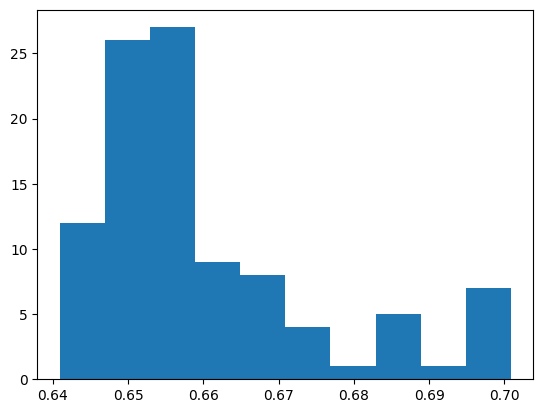

In [18]:
plt.hist(RSCV.cv_results_['mean_train_score'])
plt.show()

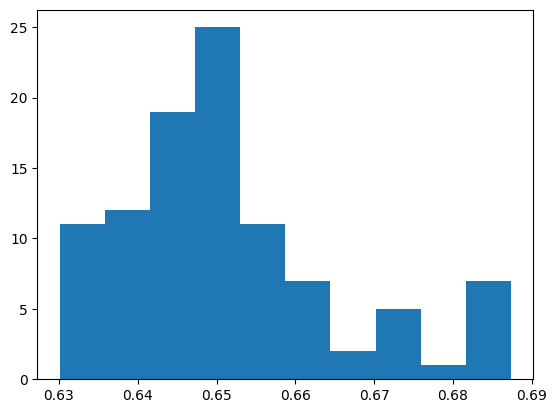

In [19]:
plt.hist(RSCV.cv_results_['mean_test_score'])
plt.show()

In [20]:
average_precision_score(y_val, RSCV.predict_proba(X_val_new)[:,1])

np.float64(0.6812191081322392)

In [21]:
log_loss(y_val, RSCV.predict_proba(X_val_new)[:,1], normalize=True)

0.30846443776337895

In [22]:
f1_score(y_val, RSCV.predict_proba(X_val_new)[:,1] > 0.356)

np.float64(0.5723076923076923)

In [23]:
precision_score(y_val, RSCV.predict_proba(X_val_new)[:,1] > 0.356)

np.float64(0.7948717948717948)

In [24]:
recall_score(y_val, RSCV.predict_proba(X_val_new)[:,1] > 0.356)

np.float64(0.44711538461538464)

# XGBoost

Ajuste do XGBoost considerando os parâmetros: quantidade de árvores (n_estimators), profundidade da árvore (max_depth), número mínimo de instância em um nó filho (min_child_weight), amostra (proporção de variáveis) de colunas para a construção de uma árvore (colsample_bytree), amostra da base de treino para a construção da árvore (subsample), amostra de colunas para a cada split/divisão de um nó pai (colsample_bynode), valor base (bias) para a predição ou predição inicial para todas as instância (base_value) e a taxa de aprendizado que é o ponderador das árvores sequenciais construídas na minimização do erro (learning_rate). A documentação para o XGBoost é: https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier.

In [45]:
if __name__ == '__main__':
    
    #test_imbalanced = [{0: len(y_treino2)/(2*np.bincount(y_treino2))[0], 1:len(y_teste2)/(2*np.bincount(y_teste2))[1]}, {0: 1, 1:1}]
    
    space = {
        "n_estimators": hp.choice('n_estimators', np.arange(10, 500, dtype=int)),
        "max_depth": hp.choice('max_depth', np.arange(10, 300, dtype=int)),
        "min_child_weight": hp.choice('min_child_weight', np.arange(100, 500, dtype=int)),
        "colsample_bytree": hp.quniform('colsample_bytree', 0.2, 1, 0.05),
        "subsample": hp.quniform('subsample', 0.2, 1, 0.05),
        "colsample_bynode": hp.quniform('colsample_bynode', 0.2, 1, 0.05),
        "base_score": hp.quniform('base_score', 0.1, 1, 0.05),
        "learning_rate": hp.quniform('learning_rate', 0.0025, 0.5, 0.025)

    }
    
    with mlflow.start_run(run_name = 'XGBoost1', experiment_id=experiment.experiment_id) as run:
        best_params = fmin(
            fn = partial(
                func_objetivo,
                expr = experiment.experiment_id,
                modelo = 'XGB',
                X_treino = X_treino2,
                X_teste = X_teste2,
                y_treino = y_treino2,
                y_teste = y_teste2
            ),
            space = space,
            algo = tpe.suggest,
            max_evals = 25,
            trials = Trials(),
            timeout = 10
        )
        
        # Identificado o melhor conjunto de hiperparâmetros, treina o modelo com toda a base de treino e metrifica os escores na base de validação

        clf = xgb.XGBClassifier(**best_params)
        clf.fit(X_treino_new, y_treino)
                   
        mlflow.log_params(clf.get_params())
        mlflow.log_metric('aucpr_val', average_precision_score(y_val, clf.predict_proba(X_val_new)[:,1]))
        mlflow.log_metric('log_loss_val', log_loss(y_val, clf.predict_proba(X_val_new)[:,1], normalize=True))
        mlflow.log_metric('roc_auc_score_val', roc_auc_score(y_val, clf.predict_proba(X_val_new)[:,1]))
        mlflow.log_metric('f1_score_val', f1_score(y_val, clf.predict(X_val_new)))
        mlflow.log_metric('f1_score_val2', f1_score(y_val, clf.predict_proba(X_val_new)[:,1] > 0.369))
        mlflow.log_metric('precision_score_val', precision_score(y_val, clf.predict(X_val_new)))
        mlflow.log_metric('precision_score_val2', precision_score(y_val, clf.predict_proba(X_val_new)[:,1] > 0.369))
        mlflow.log_metric('recall_score_val', recall_score(y_val, clf.predict(X_val_new)))
        mlflow.log_metric('recall_score_val2', recall_score(y_val, clf.predict_proba(X_val_new)[:,1] > 0.369))
        mlflow.log_metric('brier_score', brier_score_loss(y_val, clf.predict_proba(X_val_new)[:,1]))

        # Log das métricas na base de TREINO
        mlflow.log_metric('AUC_PR_Treino', average_precision_score(y_treino, clf.predict_proba(X_treino_new)[:,1]))
        mlflow.log_metric('AUC_ROC_Treino', roc_auc_score(y_treino, clf.predict_proba(X_treino_new)[:,1]))
        mlflow.log_metric('BS_Treino', brier_score_loss(y_treino, clf.predict_proba(X_treino_new)[:,1]))
        mlflow.log_metric('Log_Loss_Treino', log_loss(y_treino, clf.predict_proba(X_treino_new)[:,1], normalize=True))

        signature = infer_signature(X_treino_new, clf.predict_proba(X_treino_new))
        mlflow.sklearn.log_model(clf, signature=signature, artifact_path='modelo')

  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

/home/hugo/Documents/Git_GitHub/Estudo_Cartao_Credito/vCartao_Credito/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(



  4%|▍         | 1/25 [00:03<01:26,  3.59s/trial, best loss: 0.537490191964338]

/home/hugo/Documents/Git_GitHub/Estudo_Cartao_Credito/vCartao_Credito/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(



  8%|▊         | 2/25 [00:06<01:20,  3.48s/trial, best loss: 0.371462049758106]

/home/hugo/Documents/Git_GitHub/Estudo_Cartao_Credito/vCartao_Credito/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(



 12%|█▏        | 3/25 [00:10<01:16,  3.46s/trial, best loss: 0.371462049758106]


/home/hugo/Documents/Git_GitHub/Estudo_Cartao_Credito/vCartao_Credito/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Após a otimização de hiperparâmetros anterior, nota-se que as métricas obtidas se saíram pior do que o modelo com os hiperparâmetros default. Será otimizado somente a quantidade de árvores, produndidade das árvores e a taxa de aprendizado.

In [46]:
if __name__ == '__main__':
    
    #test_imbalanced = [{0: len(y_treino2)/(2*np.bincount(y_treino2))[0], 1:len(y_teste2)/(2*np.bincount(y_teste2))[1]}, {0: 1, 1:1}]
    
    space = {
        "n_estimators": hp.choice('n_estimators', np.arange(10, 500, dtype=int)),
        "max_depth": hp.choice('max_depth', np.arange(10, 300, dtype=int)),
        "learning_rate": hp.quniform('learning_rate', 0.0025, 0.5, 0.025)

    }
    
    with mlflow.start_run(run_name = 'XGBoost2', experiment_id=experiment.experiment_id) as run:
        best_params = fmin(
            fn = partial(
                func_objetivo,
                expr = experiment.experiment_id,
                modelo = 'XGB',
                X_treino = X_treino2,
                X_teste = X_teste2,
                y_treino = y_treino2,
                y_teste = y_teste2
            ),
            space = space,
            algo = tpe.suggest,
            max_evals = 25,
            trials = Trials(),
            timeout = 10
        )
        
        # Identificado o melhor conjunto de hiperparâmetros, treina o modelo com toda a base de treino e metrifica os escores na base de validação

        clf = xgb.XGBClassifier(**best_params)
        clf.fit(X_treino_new, y_treino)
                   
        mlflow.log_params(clf.get_params())
        mlflow.log_metric('aucpr_val', average_precision_score(y_val, clf.predict_proba(X_val_new)[:,1]))
        mlflow.log_metric('log_loss_val', log_loss(y_val, clf.predict_proba(X_val_new)[:,1], normalize=True))
        mlflow.log_metric('roc_auc_score_val', roc_auc_score(y_val, clf.predict_proba(X_val_new)[:,1]))
        mlflow.log_metric('f1_score_val', f1_score(y_val, clf.predict(X_val_new)))
        mlflow.log_metric('f1_score_val2', f1_score(y_val, clf.predict_proba(X_val_new)[:,1] > 0.369))
        mlflow.log_metric('precision_score_val', precision_score(y_val, clf.predict(X_val_new)))
        mlflow.log_metric('precision_score_val2', precision_score(y_val, clf.predict_proba(X_val_new)[:,1] > 0.369))
        mlflow.log_metric('recall_score_val', recall_score(y_val, clf.predict(X_val_new)))
        mlflow.log_metric('recall_score_val2', recall_score(y_val, clf.predict_proba(X_val_new)[:,1] > 0.369))
        mlflow.log_metric('brier_score', brier_score_loss(y_val, clf.predict_proba(X_val_new)[:,1]))

        # Log das métricas na base de TREINO
        mlflow.log_metric('AUC_PR_Treino', average_precision_score(y_treino, clf.predict_proba(X_treino_new)[:,1]))
        mlflow.log_metric('AUC_ROC_Treino', roc_auc_score(y_treino, clf.predict_proba(X_treino_new)[:,1]))
        mlflow.log_metric('BS_Treino', brier_score_loss(y_treino, clf.predict_proba(X_treino_new)[:,1]))
        mlflow.log_metric('Log_Loss_Treino', log_loss(y_treino, clf.predict_proba(X_treino_new)[:,1], normalize=True))

        signature = infer_signature(X_treino_new, clf.predict_proba(X_treino_new))
        mlflow.sklearn.log_model(clf, signature=signature, artifact_path='modelo')

  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

/home/hugo/Documents/Git_GitHub/Estudo_Cartao_Credito/vCartao_Credito/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(



  4%|▍         | 1/25 [00:03<01:31,  3.81s/trial, best loss: 0.308468871085698]

/home/hugo/Documents/Git_GitHub/Estudo_Cartao_Credito/vCartao_Credito/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(



  8%|▊         | 2/25 [00:08<01:36,  4.20s/trial, best loss: 0.30027406175887905]

/home/hugo/Documents/Git_GitHub/Estudo_Cartao_Credito/vCartao_Credito/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(



 12%|█▏        | 3/25 [00:12<01:29,  4.06s/trial, best loss: 0.25432779501366215]


/home/hugo/Documents/Git_GitHub/Estudo_Cartao_Credito/vCartao_Credito/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Abaixo, a otimização desconsidera a taxa de aprendizado.

In [47]:
if __name__ == '__main__':
    
    #test_imbalanced = [{0: len(y_treino2)/(2*np.bincount(y_treino2))[0], 1:len(y_teste2)/(2*np.bincount(y_teste2))[1]}, {0: 1, 1:1}]
    
    space = {
        "n_estimators": hp.choice('n_estimators', np.arange(10, 500, dtype=int)),
        "max_depth": hp.choice('max_depth', np.arange(10, 300, dtype=int))

    }
    
    with mlflow.start_run(run_name = 'XGBoost3', experiment_id=experiment.experiment_id) as run:
        best_params = fmin(
            fn = partial(
                func_objetivo,
                expr = experiment.experiment_id,
                modelo = 'XGB',
                X_treino = X_treino2,
                X_teste = X_teste2,
                y_treino = y_treino2,
                y_teste = y_teste2
            ),
            space = space,
            algo = tpe.suggest,
            max_evals = 25,
            trials = Trials(),
            timeout = 10
        )
        
        # Identificado o melhor conjunto de hiperparâmetros, treina o modelo com toda a base de treino e metrifica os escores na base de validação

        clf = xgb.XGBClassifier(**best_params)
        clf.fit(X_treino_new, y_treino)
                   
        mlflow.log_params(clf.get_params())
        mlflow.log_metric('aucpr_val', average_precision_score(y_val, clf.predict_proba(X_val_new)[:,1]))
        mlflow.log_metric('log_loss_val', log_loss(y_val, clf.predict_proba(X_val_new)[:,1], normalize=True))
        mlflow.log_metric('roc_auc_score_val', roc_auc_score(y_val, clf.predict_proba(X_val_new)[:,1]))
        mlflow.log_metric('f1_score_val', f1_score(y_val, clf.predict(X_val_new)))
        mlflow.log_metric('f1_score_val2', f1_score(y_val, clf.predict_proba(X_val_new)[:,1] > 0.369))
        mlflow.log_metric('precision_score_val', precision_score(y_val, clf.predict(X_val_new)))
        mlflow.log_metric('precision_score_val2', precision_score(y_val, clf.predict_proba(X_val_new)[:,1] > 0.369))
        mlflow.log_metric('recall_score_val', recall_score(y_val, clf.predict(X_val_new)))
        mlflow.log_metric('recall_score_val2', recall_score(y_val, clf.predict_proba(X_val_new)[:,1] > 0.369))
        mlflow.log_metric('brier_score', brier_score_loss(y_val, clf.predict_proba(X_val_new)[:,1]))

        # Log das métricas na base de TREINO
        mlflow.log_metric('AUC_PR_Treino', average_precision_score(y_treino, clf.predict_proba(X_treino_new)[:,1]))
        mlflow.log_metric('AUC_ROC_Treino', roc_auc_score(y_treino, clf.predict_proba(X_treino_new)[:,1]))
        mlflow.log_metric('BS_Treino', brier_score_loss(y_treino, clf.predict_proba(X_treino_new)[:,1]))
        mlflow.log_metric('Log_Loss_Treino', log_loss(y_treino, clf.predict_proba(X_treino_new)[:,1], normalize=True))

        # Log das métricas na base de TREINO
        mlflow.log_metric('AUC_PR_Treino', average_precision_score(y_treino, clf.predict_proba(X_treino_new)[:,1]))
        mlflow.log_metric('AUC_ROC_Treino', roc_auc_score(y_treino, clf.predict_proba(X_treino_new)[:,1]))
        mlflow.log_metric('BS_Treino', brier_score_loss(y_treino, clf.predict_proba(X_treino_new)[:,1]))
        mlflow.log_metric('Log_Loss_Treino', log_loss(y_treino, clf.predict_proba(X_treino_new)[:,1], normalize=True))

        signature = infer_signature(X_treino_new, clf.predict_proba(X_treino_new))
        mlflow.sklearn.log_model(clf, signature=signature, artifact_path='modelo')

  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

/home/hugo/Documents/Git_GitHub/Estudo_Cartao_Credito/vCartao_Credito/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(



  4%|▍         | 1/25 [00:03<01:26,  3.62s/trial, best loss: 0.26298507242412356]

/home/hugo/Documents/Git_GitHub/Estudo_Cartao_Credito/vCartao_Credito/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(



  8%|▊         | 2/25 [00:07<01:28,  3.83s/trial, best loss: 0.26298507242412356]

/home/hugo/Documents/Git_GitHub/Estudo_Cartao_Credito/vCartao_Credito/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(



 12%|█▏        | 3/25 [00:11<01:24,  3.84s/trial, best loss: 0.26298507242412356]


/home/hugo/Documents/Git_GitHub/Estudo_Cartao_Credito/vCartao_Credito/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


# Conlusão 2

Recapitulação:

    1. Foi considerado um conjunto menor de variáveis para os modelos, filtradas por importância acumulada e IV;

    2. Estudou-se o melhor ponto de corte, considerando o modelo com hiperparâmetro default e a validação cruzada; além disso, métricas médias de AUCPR, log-loss e BS foram calculadas usando os folds de validação;

    3. Procura do melhor conjunto de hiperparâmetros, com o equilíbrio nas métricas de treino e validação.

Dos resultados logados no mlflow, consegue-se perceber que:

    1. os dois melhores modelos são uma RF e um XGBoost. 
        
        a. RF: AUC_PR_Treino = 0.76, BS_Treino = 0.08, Log_Loss_Treino = 0.26, AUC_PR_Val = 0.73, BS_Val = 0.08, Log_Loss_Val = 0.28;

        b. XGboost: AUC_PR_Treino = 0.68, BS_Treino = 0.08, Log_Loss_Treino = 0.28, AUC_PR_Val = 0.67, BS_Val = 0.085, Log_Loss_Val = 0.29.

    2. as métricas anteriores estão próximas o suficiente para que se possa concluir que não há evidências de sobreajuste em treino e com boa capacidade de generalização em validação.

    3. Ao usar os pontos de corte default, outras métricas em validação foram analisadas:

        a. RF: f1-score =  0.44, recall = 0.29 e precision = 0.88;

        b. XGBoost: f1-score =  0.54, recall = 0.41 e precision = 0.77.

    4. pode-se encontrar o ponto ótimo para o conjunto de hiperparâmetro do passo 3 e também pode-se pensar em um blend desses dois modelos, para avaliar um ganho de performance.

# Melhor ponto de corte

In [50]:
# RF
logged_model_RF = 'runs:/c189498258a44951985fd8b97a019cf2/modelo'
best_RF = mlflow.sklearn.load_model(logged_model_RF)

# XGBoost
logged_model_XGB = 'runs:/c7b11305d2a04d75b9f42036a478fa58/modelo'
best_XGB = mlflow.sklearn.load_model(logged_model_XGB)

In [54]:
pontos_rf = []
pontos_xgb = []
f1_rf = []
f1_xgb = []

SKF = StratifiedKFold(n_splits=5, shuffle=True, random_state=563)

for i, (treino_index, teste_index) in enumerate(SKF.split(X_treino_new, y_treino)):
    
    # Marcação do fold
    
    print(f"Fold {i}")
    
    # Divisão das bases de treino e teste
    
    X_treino_aux, X_teste_aux = X_treino_new.iloc[treino_index,:], X_treino_new.iloc[teste_index, :]
    y_treino_aux, y_teste_aux = y_treino[treino_index], y_treino[teste_index]

    # Aplicação da RF e XGB
    
    best_RF.fit(X_treino_aux, y_treino_aux)
    best_XGB.fit(X_treino_aux, y_treino_aux)


    # Métricas RF

    # Avaliação do melhor ponto de corte com o uso da base de validação

    precision_RF, recall_RF, thresholds_RF = precision_recall_curve(y_teste_aux, best_RF.predict_proba(X_teste_aux)[:,1])

    # Melhor threshold que fornece o melhor f1-score (média harmônica entre precisão (Positive Predicted Value ou PPV) e recall (TPR))

    f1_scores_RF = 2 * (precision_RF*recall_RF) / (precision_RF + recall_RF)
    best_threshold_index_RF = np.argmax(f1_scores_RF)
    best_threshold_RF = thresholds_RF[best_threshold_index_RF]
    best_f1_RF = f1_scores_RF[best_threshold_index_RF]
    
    pontos_rf.append(best_threshold_RF)
    f1_rf.append(best_f1_RF)

    
    # Métricas XGB

    # Avaliação do melhor ponto de corte com o uso da base de validação

    precision_XGB, recall_XGB, thresholds_XGB = precision_recall_curve(y_teste_aux, best_XGB.predict_proba(X_teste_aux)[:,1])

    # Melhor threshold que fornece o melhor f1-score (média harmônica entre precisão (Positive Predicted Value ou PPV) e recall (TPR))

    f1_scores_XGB = 2 * (precision_XGB*recall_XGB) / (precision_XGB + recall_XGB)
    best_threshold_index_XGB = np.argmax(f1_scores_XGB)
    best_threshold_XGB = thresholds_XGB[best_threshold_index_XGB]
    best_f1_XGB = f1_scores_XGB[best_threshold_index_XGB]
    
    pontos_xgb.append(best_threshold_XGB)
    f1_xgb.append(best_f1_XGB)

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


In [55]:
np.mean(pontos_rf), np.std(pontos_rf), np.mean(f1_rf)

(np.float64(0.313385883698052),
 np.float64(0.01869767169731388),
 np.float64(0.6864579204427246))

In [56]:
np.mean(pontos_xgb), np.std(pontos_xgb), np.mean(f1_xgb)

(np.float32(0.32041183),
 np.float32(0.045523874),
 np.float64(0.6232342904811781))